In [1]:
!pip install eli5
!pip install shap

     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 266kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383174 sha256=1cade90792bc4cc4a22fa15e9f5462a19ba5835ac02d48dbef5b71899f0041c2
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [2]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

# GPUの確認
import torch
use_gpu = torch.cuda.is_available()
print(use_gpu)

     |████████████████████████████████| 592.3MB 1.2MB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 0.3.0.post4 which is incompatible.
ERROR: fastai 1.0.59 has requirement torch>=1.0.0, but you'll have torch 0.3.0.post4 which is incompatible.
True


In [0]:
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
# from sklearn.cross_validation import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import io
# import pandas_profiling as pdp
import re

In [6]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [7]:
# Load the data
df_data = pd.read_csv('train.csv', header=0)
df_submission = pd.read_csv('test.csv', header=0)
df_both = df_data.append(df_submission)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [12]:
display(df_both.columns.to_list())
display(df_both.describe())

['Age',
 'Cabin',
 'Embarked',
 'Fare',
 'Name',
 'Parch',
 'PassengerId',
 'Pclass',
 'Sex',
 'SibSp',
 'Survived',
 'Ticket']

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [0]:
# 変数を作成する
# Cabinにいたか
df_both['in_cabin'] = 1
df_both.loc[df_both['Cabin'].isnull(), 'in_cabin'] = 0


# Cabinを複数人でシェアしていたか
df_c = df_both[['Cabin']].copy()
df_c['cabin_shared'] = 1
df_c = df_c.groupby('Cabin').sum().reset_index()

df_both = pd.merge(df_both, df_c, how='left', on=['Cabin'])
df_both['cabin_shared'].fillna(0, inplace=True)
df_both['cabin_shared'] = df_both['cabin_shared'].apply(lambda x : 2 if x > 1 else 0)


# 家族数
df_both['familySize'] = df_both['SibSp'] + df_both['Parch'] + 1
df_both['is_alone'] = df_both['familySize'].apply(lambda x: 1 if x == 1 else 0)

# 敬称を抽出
df_both['Salutation'] = 'others'
df_both.loc[df_both['Name'].apply(lambda x: ', Miss.' in x), 'Salutation'] = 'Miss'
df_both.loc[df_both['Name'].apply(lambda x: ', Mlle.' in x), 'Salutation'] = 'Miss'
df_both.loc[df_both['Name'].apply(lambda x: ', Ms.' in x), 'Salutation'] = 'Miss'
df_both.loc[df_both['Name'].apply(lambda x: ', Mr.' in x), 'Salutation'] = 'Mr' 
df_both.loc[df_both['Name'].apply(lambda x: ', Mrs.' in x), 'Salutation'] = 'Mrs'
df_both.loc[df_both['Name'].apply(lambda x: ', Mme' in x), 'Salutation'] = 'Mrs'
df_both.loc[df_both['Name'].apply(lambda x: ', Sir' in x), 'Salutation'] = 'Sir'
df_both.loc[df_both['Name'].apply(lambda x: ', Master' in x), 'Salutation'] = 'Master'
df_both.loc[df_both['Name'].apply(lambda x: ', Rev.' in x), 'Salutation'] = 'Rev'
df_both.loc[df_both['Name'].apply(lambda x: ', Don.' in x), 'Salutation'] = 'Rev'
# df_both.loc[df_both['Name'].apply(lambda x: ', Dr.' in x), 'Salutation'] = 'Dr'

# Golden Ticket
df_both['golden_ticket'] = df_both['Ticket'].apply(lambda x: 1 
                                                   if (len(x) == 4) 
                                                   or (len(x) == 5 and x[0] in ('1', '2'))
                                                   or (len(x) == 6 and x[0] in ('3'))
                                                   or (len(x) == 7 and x.startswith('PP'))
                                                   or (len(x) == 7 and x.startswith('C '))
                                                   or (len(x) == 9 and x.startswith('C.'))
                                                   or (len(x) == 10 and x.startswith('C.'))
                                                   or x.startswith('PC ')
                                                   or x.startswith('STON/')
                                                   else 0)

# Embarked
df_both['Embarked_n'] = 0
df_both.loc[df_both['Embarked'] == 'Q', 'Embarked_n'] = 1
df_both.loc[df_both['Embarked'] == 'C', 'Embarked_n'] = 2

# 家族属性
df_both['is_family_boy'] = df_both.apply(lambda row: 1 if row['Salutation'] == 'Master' and row['familySize'] in (2, 3, 4) else 0, axis=1)
df_both['is_large_family'] = df_both.apply(lambda row: 1 if row['familySize'] > 4 else 0, axis=1)

# Cabin x Salutation
# df_both['cabin_shared_mr'] = df_both.apply(lambda row: 1 if row['Salutation'] == 'Mr' and row['cabin_shared'] == 2 else 0, axis=1)

In [0]:
# 敬称を平均生存率への影響度に置き換える
salutations = list(set(df_both['Salutation']))
ave_survival_rate = df_both['Survived'].mean()

salutations_impact = {}

for s in salutations:
  impact = df_both[df_both['Salutation'] != s]['Survived'].mean() - ave_survival_rate
  salutations_impact.update({s: impact})

df_both['salutation_impact'] = df_both['Salutation'].apply(lambda x: salutations_impact[x])

In [0]:
# チケット価格
df_t = df_both[['Pclass', 'familySize', 'Fare']].groupby(['Pclass', 'familySize'], as_index=False).median().rename(columns={'Fare': 'fare_med'})
df_both = pd.merge(df_both, df_t, how='left', on=['Pclass', 'familySize'])
df_both['high_fare'] = df_both.apply(lambda row: row['Fare'] / row['fare_med'], axis=1)

In [17]:
df_both.columns.to_list()

['Age',
 'Cabin',
 'Embarked',
 'Fare',
 'Name',
 'Parch',
 'PassengerId',
 'Pclass',
 'Sex',
 'SibSp',
 'Survived',
 'Ticket',
 'in_cabin',
 'cabin_shared',
 'familySize',
 'is_alone',
 'Salutation',
 'golden_ticket',
 'Embarked_n',
 'is_family_boy',
 'is_large_family',
 'salutation_impact',
 'fare_med',
 'high_fare']

In [0]:
nonnumeric_columns = [
    'Sex'
]
feature_columns_to_use = [
    'Pclass', 
    'golden_ticket',
    'is_family_boy',
    'cabin_shared',
    'high_fare',
    'is_large_family',
    # 'Embarked_n', 
    'salutation_impact'
] + nonnumeric_columns

In [21]:
cut_vals = [[c] for c in feature_columns_to_use]

for c in cut_vals:
  display(df_both[c + ['Survived']].groupby(c).agg({'Survived': ['mean', 'count']}).reset_index())

Pclass  Survived      
              mean count
0      1  0.629630   216
1      2  0.472826   184
2      3  0.242363   491

golden_ticket  Survived      
                     mean count
0             0  0.375385   325
1             1  0.388693   566

is_family_boy  Survived      
                     mean count
0             0  0.368239   869
1             1  1.000000    22

cabin_shared  Survived      
                    mean count
0            0  0.321522   762
1            2  0.751938   129

high_fare  Survived      
                    mean count
0     0.000000  0.066667    15
1     0.159543  0.000000     1
2     0.219369       NaN     0
3     0.248601       NaN     0
4     0.253397  1.000000     1
..         ...       ...   ...
348   7.187226  1.000000     1
349   7.193069  0.714286     7
350   7.259984  0.666667     3
351   8.371996       NaN     0
352  16.347662  1.000000     2

[353 rows x 3 columns]

is_large_family  Survived      
                       mean count
0               0  0.400483   829
1               1  0.161290    62

salutation_impact  Survived      
                         mean count
0         -0.083555  0.702703   185
1         -0.067499  0.793651   126
2         -0.008985  0.575000    40
3         -0.001418  0.466667    15
4         -0.000692  1.000000     1
5          0.003039  0.000000     7
6          0.314023  0.156673   517

Sex  Survived      
               mean count
0  female  0.742038   314
1    male  0.188908   577

In [22]:
df_both[feature_columns_to_use].head()

,Pclass,golden_ticket,is_family_boy,cabin_shared,high_fare,is_large_family,salutation_impact,Sex
0,3,0,0,0,0.501584,0,0.314023,male
1,1,1,0,2,1.000000,0,-0.067499,female
2,3,1,0,0,1.009014,0,-0.083555,female
3,1,0,0,2,0.744915,0,-0.067499,female
4,3,1,0,0,1.024929,0,0.314023,male


In [0]:
le = LabelEncoder()
for feature in nonnumeric_columns:
    df_both[feature] = le.fit_transform(df_both[feature])

In [24]:
df_both.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,in_cabin,cabin_shared,familySize,is_alone,Salutation,golden_ticket,Embarked_n,is_family_boy,is_large_family,salutation_impact,fare_med,high_fare
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,0,0,2,0,Mr,0,0,0,0,0.314023,14.4542,0.501584
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,1,2,2,0,Mrs,1,2,0,0,-0.067499,71.2833,1.000000
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,0,0,1,1,Miss,1,0,0,0,-0.083555,7.8542,1.009014
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,1,2,2,0,Mrs,0,0,0,0,-0.067499,71.2833,0.744915
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,0,0,1,1,Mr,1,0,0,0,0.314023,7.8542,1.024929


In [0]:
df_data = df_both[df_both['Survived'].notnull()].copy()
df_submission = df_both[df_both['Survived'].isnull()].copy()

X = df_data[feature_columns_to_use]
y = df_data['Survived']

from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
X_train.head()

,Pclass,golden_ticket,is_family_boy,cabin_shared,high_fare,is_large_family,salutation_impact,Sex
140,3,1,0,0,0.983600,0,-0.067499,0
439,2,1,0,0,0.807692,0,0.314023,1
817,2,0,0,0,1.409684,0,0.314023,1
378,3,1,0,0,0.510873,0,0.314023,1
491,3,0,0,0,0.923073,0,0.314023,1


In [38]:
# scikit-learn を用いた交差検証（Cross-validation）とハイパーパラメータのチューニング（grid search）
# https://qiita.com/tomov3/items/039d4271ed30490edf7b

xgb_model = xgb.XGBClassifier()
xgb_params = {
    'objective': ['binary:logistic'],
    'learning_rate': [0.1, 0.2],     # so called `eta` value
    'gamma': [1],
    'max_depth': [4, 5],
    'min_child_weight': [10, 15],
    'silent': [1],
    'subsample': [0.5, 0.6],
    'colsample_bytree': [0.7, 0.8],
    'n_estimators': [500, 700],     # number of trees, change it to 1000 for better results
    'seed': [1337]
}

rf_model = RandomForestClassifier()
rf_params = {
    'n_estimators'      : [700, 800, 1000],
    'max_features'      : ['auto'],
    'criterion'         : ['entropy', 'gini'],
    'random_state'      : [0],
    'n_jobs'            : [5],
    'min_samples_split' : [10, 12, 15, 18],
    'max_depth'         : [10, 12, 15, 18],
}

model = rf_model
params = rf_params

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X_train, y_train)

clf = GridSearchCV(model, params, n_jobs=5, 
                   cv=skf, 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   49.6s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  8.4min
[Parallel(n_jobs=5)]: Done 480 out of 480 | elapsed: 11.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fract...
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='warn', n_jobs=5,

In [46]:
max_index = clf.cv_results_['mean_test_score'].argmax()
score = clf.cv_results_['mean_test_score'][max_index]
best_parameters = clf.cv_results_['params'][max_index]

print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Raw AUC score: 0.8755679922530223
criterion: 'gini'
max_depth: 10
max_features: 'auto'
min_samples_split: 12
n_estimators: 700
n_jobs: 5
random_state: 0


In [47]:
thres = [0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54]

df_test_result = X_test.copy()
df_test_result['Survived'] = y_test
df_test_result['score'] = [p[1] for p in clf.predict_proba(X_test)]

best_thres = thres[0]
best_score = 0
for t in thres:
  df_test_result['pred'] = df_test_result['score'].apply(lambda x: int(x + t))

  df_test_result['match'] = df_test_result.apply(lambda row: 1 if row['pred'] == row['Survived'] else 0, axis=1)
  score = df_test_result['match'].mean()
  display(t, score)
  
  if score > best_score:
    best_thres = t
    best_score = score
    display('best thres is updated to {}'.format(t))

df_test_result['pred'] = df_test_result['score'].apply(lambda x: int(x + best_thres))

0.46

0.8715083798882681

'best thres is updated to 0.46'

0.47

0.8715083798882681

0.48

0.8603351955307262

0.49

0.8603351955307262

0.5

0.8659217877094972

0.51

0.8659217877094972

0.52

0.8603351955307262

0.53

0.8603351955307262

0.54

0.8659217877094972

In [48]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Using TensorFlow backend.


Weight,Feature
0.0989 ± 0.0320,salutation_impact
0.0712 ± 0.0140,Pclass
0.0363 ± 0.0255,Sex
0.0287 ± 0.0110,high_fare
0.0203 ± 0.0153,golden_ticket
0.0145 ± 0.0147,cabin_shared
0.0103 ± 0.0075,is_large_family
0.0064 ± 0.0071,is_family_boy


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


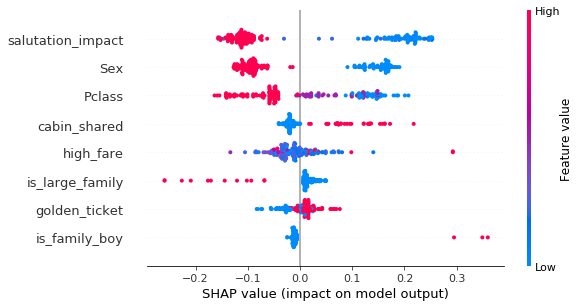

In [49]:
rf_params = {
    'n_estimators'      : 700,
    'max_features'      : 'auto',
    'criterion'         : 'gini',
    'random_state'      : 0,
    'n_jobs'            : 5,
    'min_samples_split' : 10,
    'max_depth'         : 10,
}
clf_best = RandomForestClassifier(**rf_params)
clf_best.fit(X_train, y_train)

import shap
explainer = shap.TreeExplainer(clf_best)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

In [50]:
for c in feature_columns_to_use:
  display(df_test_result[[c, 'Survived', 'match']].groupby([c, 'Survived']).agg({'match': ['mean', 'sum', 'count']}))

match          
                     mean sum count
Pclass Survived                    
1      0.0       0.714286  10    14
       1.0       0.875000  28    32
2      0.0       0.900000  18    20
       1.0       0.944444  17    18
3      0.0       0.868421  66    76
       1.0       0.842105  16    19

match          
                            mean sum count
golden_ticket Survived                    
0             0.0       0.861111  31    36
              1.0       0.920000  23    25
1             0.0       0.851351  63    74
              1.0       0.863636  38    44

match          
                            mean sum count
is_family_boy Survived                    
0             0.0       0.854545  94   110
              1.0       0.878788  58    66
1             1.0       1.000000   3     3

match          
                           mean sum count
cabin_shared Survived                    
0            0.0       0.854369  88   103
             1.0       0.840909  37    44
2            0.0       0.857143   6     7
             1.0       0.960000  24    25

match          
                        mean sum count
high_fare Survived                    
0.000000  0.0       0.666667   2     3
0.466400  0.0       1.000000   1     1
0.487457  0.0       1.000000   1     1
0.506723  0.0       1.000000   1     1
0.536176  0.0       1.000000   1     1
...                      ...  ..   ...
3.472353  1.0       1.000000   1     1
4.835735  1.0       1.000000   1     1
4.896760  1.0       1.000000   1     1
7.193069  1.0       1.000000   2     2
7.259984  1.0       1.000000   1     1

[112 rows x 3 columns]

match          
                              mean sum count
is_large_family Survived                    
0               0.0       0.838384  83    99
                1.0       0.882353  60    68
1               0.0       1.000000  11    11
                1.0       1.000000   1     1

match          
                                mean sum count
salutation_impact Survived                    
-0.083555         0.0       0.333333   4    12
                  1.0       1.000000  25    25
-0.067499         0.0       0.500000   3     6
                  1.0       1.000000  23    23
-0.008985         0.0       1.000000   2     2
                  1.0       1.000000   3     3
-0.001418         0.0       0.000000   0     4
                  1.0       1.000000   2     2
 0.003039         0.0       1.000000   4     4
 0.314023         0.0       0.987805  81    82
                  1.0       0.500000   8    16

match          
                  mean sum count
Sex Survived                    
0   0.0       0.388889   7    18
    1.0       1.000000  49    49
1   0.0       0.945652  87    92
    1.0       0.600000  12    20

In [0]:
thres = best_thres
df_submission['high_fare'].fillna(1, inplace=True)
df_submission['Survived'] = [int(p[1] + thres) for p in clf.predict_proba(df_submission[feature_columns_to_use])]

In [0]:
df_submission[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)
files.download('submission.csv')

In [0]:
df_test_result.to_csv('detail.csv', index=False)
files.download('detail.csv')